In [78]:
# Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
# istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

In [79]:
# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

In [80]:
# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [81]:
# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [83]:
df = pd.read_csv("/content/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [87]:
# Genel olarak bir veri setimize bakalım
def check_df(dataframe, head=5):
  print("##################### Shape ##################### ")
  print(dataframe.shape)
  print("##################### Types ##################### ")
  print(dataframe.dtypes)
  print("##################### Head ##################### ")
  print(dataframe.head(head))
  print("##################### Tail ##################### ")
  print(dataframe.tail(head))
  print("##################### NA ##################### ")
  print(dataframe.isnull().sum())
  print("###################### Quanties ###################### ")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [90]:
check_df(df)

##################### Shape ##################### 
(768, 9)
##################### Types ##################### 
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head ##################### 
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  \
0            6      148             72             35        0 33.600                     0.627   
1            1       85             66             29        0 26.600                     0.351   
2            8      183             64              0        0 23.300                     0.672   
3            1       89             66             23       94 28.100                     0.167   
4     

In [91]:
# Üstteki yazdığımız fonksiyon sonucunda Quantiles kısmına bakınca bize belirli veriler sunuyor
# Kişilerin BloodPressure ve Glucose  seviyesi 0 olamaz. Büyük ihtimal bu veri setinde None değerlerin yerine 0 yazılmış.
# Ek olarakta Insulin de %99 ve %100 arasında bir sıçrama var. Aykırı değer olabilir.

In [92]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"observations: {dataframe.shape[0]}")
  print(f"variables: {dataframe.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car: {len(cat_but_car)}")
  print(f"num_but_cat: {len(num_but_cat)}")
  return cat_cols, num_cols, cat_but_car

In [93]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 768
variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [94]:
grab_col_names(df)

observations: 768
variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [])

In [95]:
# Kategorik Değişkenlerimizi Analiz Edelim

def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show()


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


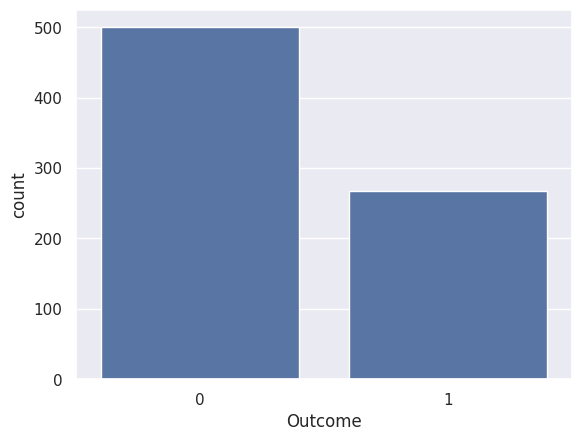

In [96]:
cat_summary(df, "Outcome", True)

In [97]:
# Numerik Değişken Analizi

def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)


  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


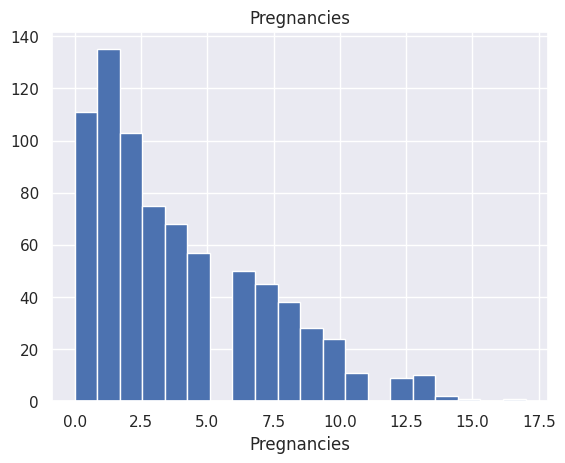

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


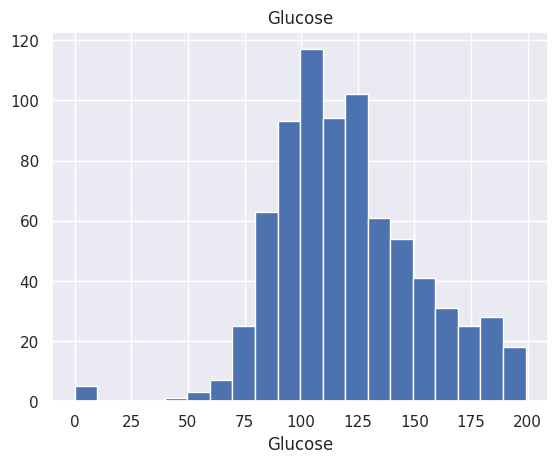

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


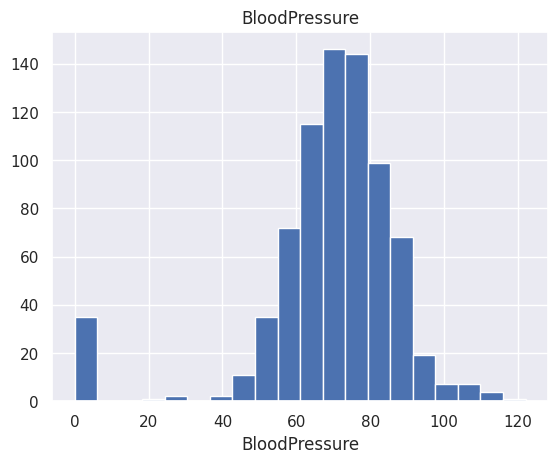

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


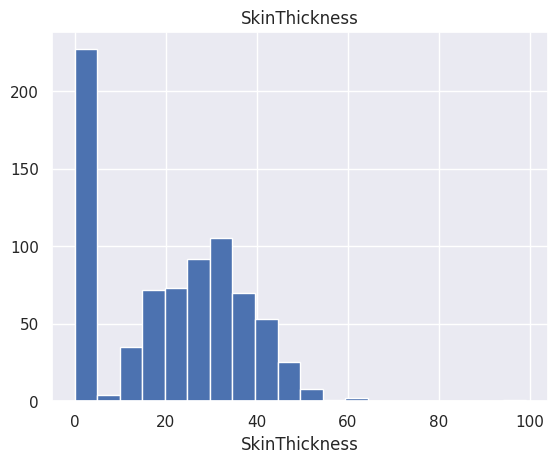

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


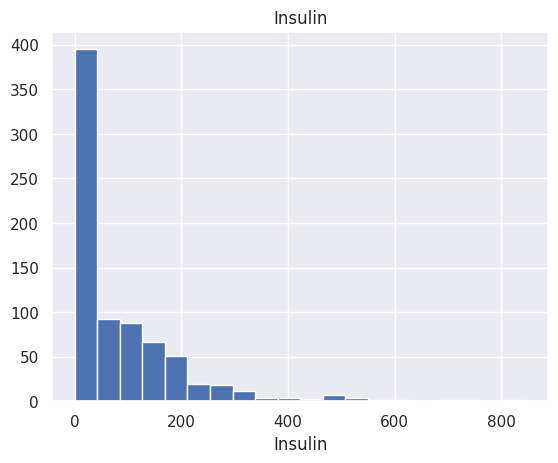

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


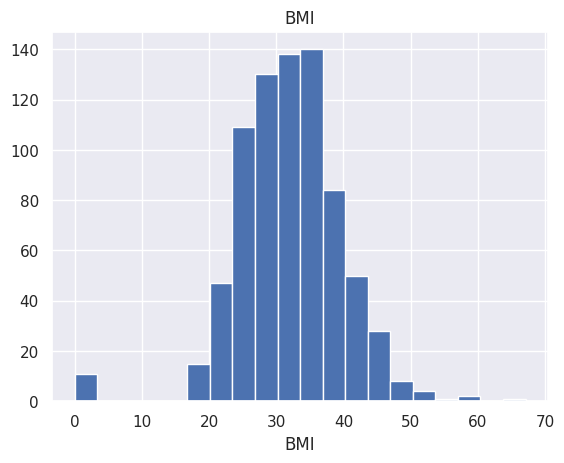

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


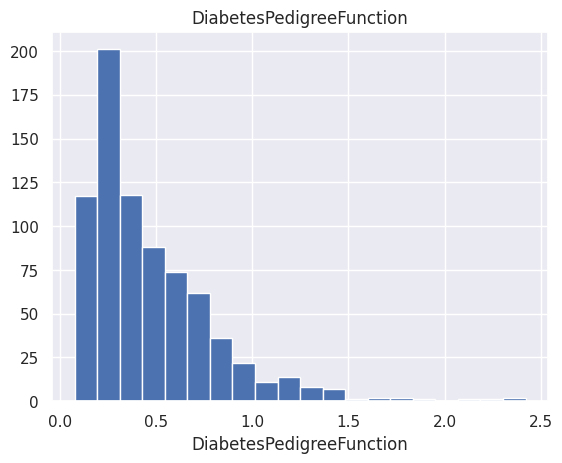

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


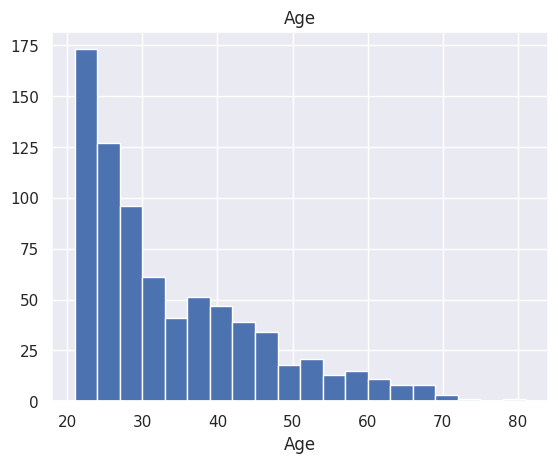

In [98]:
for col in num_cols:
  num_summary(df, col, plot=True)

In [99]:
# Numerik Değişkenlerin Hedef Değişkene Göre Analizi

def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [100]:
for col in num_cols:
  target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [101]:
# KORELASYON

In [102]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


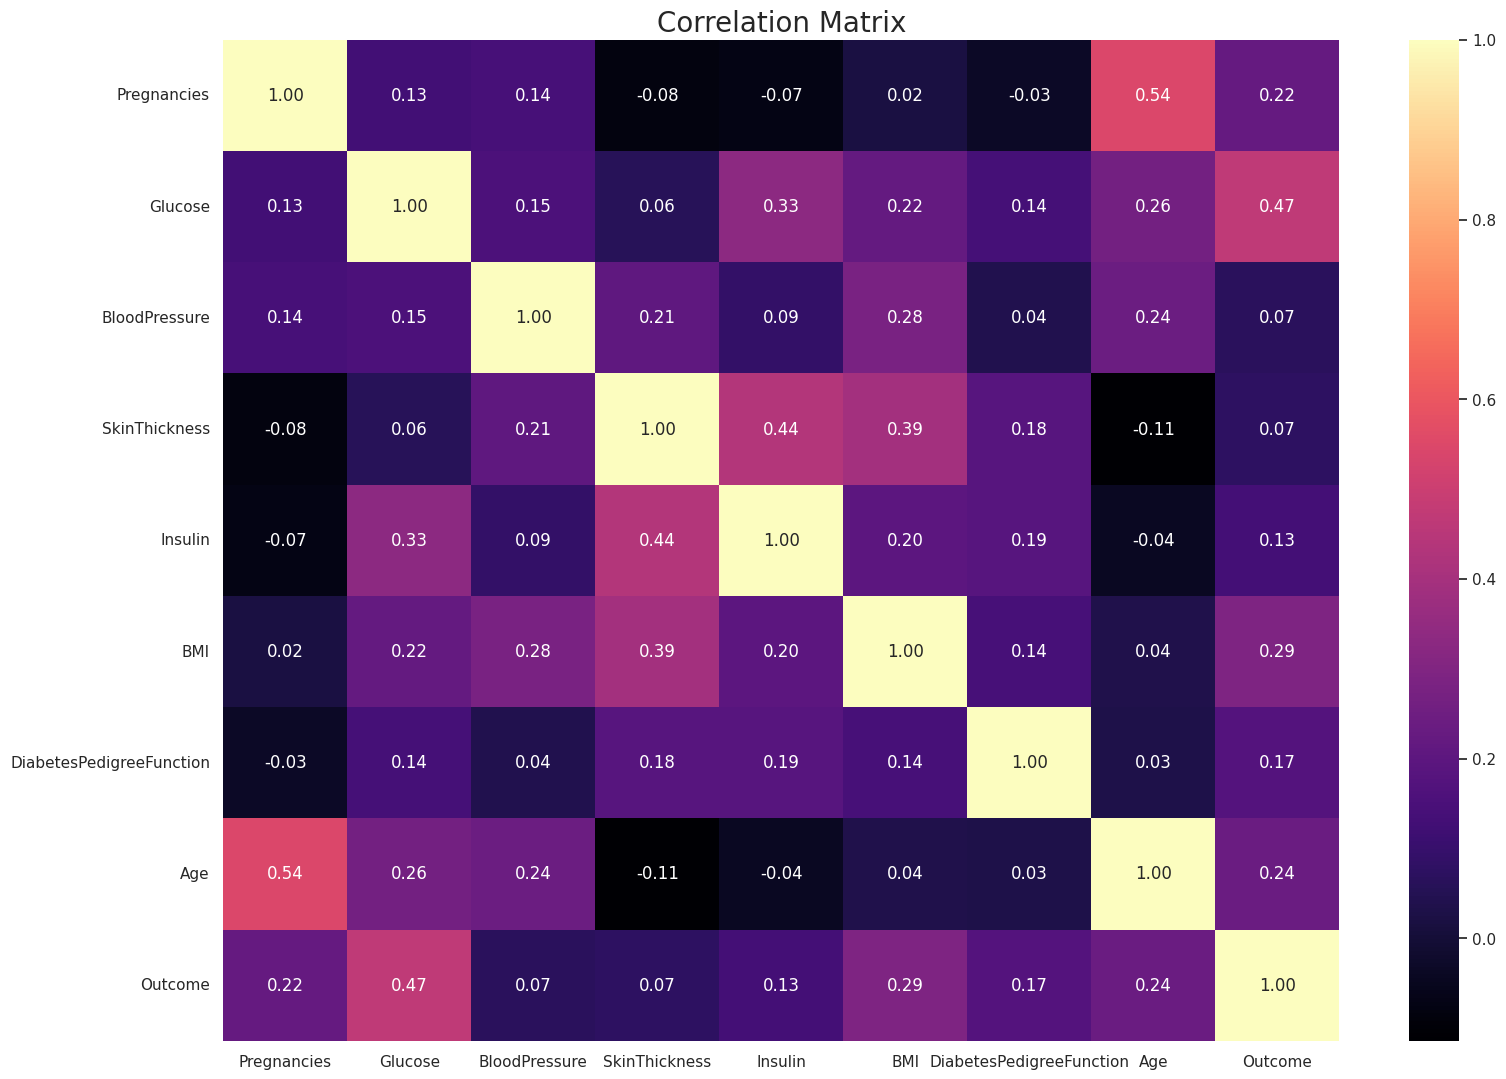

In [103]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [104]:
# Eksik Değer Analizi

In [105]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olmayacağı bilinmektedir.
# Bundan dolayı bu değerlerle ilgili aksiyon almalıyız. 0 olan değerleri NaN yapacacağız.

In [106]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

In [107]:
# Şimdi gözlem birimlerinde 0 olan değişkenlerin her birine gidip 0 içeren gözlem değerlerini NaN ile değiştirelim
for col in zero_columns:
  df[col] = np.where(df[col] == 0, np.nan, df[col])  # Verdiğimiz koşul eğer sağlanıyorsa np.nan ile değiştireceğiz eğer sağlanmıyorsa olduğu gibi bırakacağız

In [108]:
# Eksik Değerlerimize Bakalım
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [109]:
# İlk başta eksik değer yoktu fakat 0 değerlerini NaN ile değiştirince eksik değerlerimiz ortaya çıktı

In [110]:
# Eksik değer varsa eksik değerlerin toplamını ve oranını yazdıran fonksiyon
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df, end="\n")

  if na_name:
    return na_columns

In [111]:
na_columns = missing_values_table(df, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [112]:
# Eksik değerlerin bağımlı değişken ile ilişkisini inceleyelim

def missing_vs_target(dataframe, target, na_columns):
  temp_df = dataframe.copy()
  for col in na_columns:
    temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0)
  na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
  for col in na_flags:
    print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                          "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [114]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [115]:
# Eksik Değerlerin Doldurulması
for col in zero_columns:
  df.loc[df[col].isnull(), col] = df[col].median()

In [116]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [117]:
# Aykırı Değer Analizi

In [118]:
# Öyle bir fonksiyon yazalım ki kendisine girilen değerlerin eşik değerlerini hesaplıyor olsun
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

In [119]:
# Şimdi aykırı değer var mı yok mu diye bir fonk yazalım

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [120]:
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit) , variable] = low_limit   # Alt aykırı değer varsa low_limit ' e eşitle
  dataframe.loc[(dataframe[variable] > up_limit) , variable] = up_limit     # Üst aykırı değer varsa up_limit ' e eşitle

In [121]:
# Aykırı Değer Analizi ve Baskılama İşlemi

for col in df.columns:
  print(col, check_outlier(df, col))
  if check_outlier(df, col):
    replace_with_thresholds(df, col)

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [122]:
for col in df.columns:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [123]:
# Özellik Çıkarımı

In [124]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [125]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [126]:
# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [127]:
# # Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [128]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [129]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [130]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

In [131]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

In [132]:
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [133]:
# Kolon isimlerini büyük harfle yazalım
df.columns = [col.upper() for col in df.columns]

In [134]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10045.875,89.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,mature,Obese,Normal,obesemature,highmature,Normal,18614.875,0.000


In [135]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 768
variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [136]:
# Label Encoding

def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [137]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['NEW_AGE_CAT']


In [138]:
for col in binary_cols:
  df = label_encoder(df, col)

In [139]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10045.875,89.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,Obese,Normal,obesemature,highmature,Normal,18614.875,0.000


In [140]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncellenme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
print(cat_cols)

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_INSULIN_SCORE', 'NEW_BMI', 'NEW_GLUCOSE']


In [141]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10045.875,89.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,Obese,Normal,obesemature,highmature,Normal,18614.875,0.000


In [142]:
df.shape

(768, 17)

In [143]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  return dataframe

In [144]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [145]:
df.shape

(768, 26)

In [146]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,18500.000,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,10625.000,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,22875.000,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,10045.875,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,18614.875,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [147]:
# Standartlaşma
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [148]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [149]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,1,0.750,0.893,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,0,-1.078,-0.864,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,0,1.766,2.154,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0,-1.212,-0.855,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,0,0.777,-1.050,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [150]:
# Label Encoding fonksiyonu
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [151]:
# Sadece True/False olan sütunları seçme
binary_cols = [col for col in df.columns if df[col].dtype == "bool"]

In [152]:
for col in binary_cols:
    df = label_encoder(df, col)

In [153]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,1,0.750,0.893,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,0,-1.078,-0.864,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,0,1.766,2.154,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0,-1.212,-0.855,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,0,0.777,-1.050,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [154]:
# MODELLEME
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")


Accuracy: 0.8
Recall: 0.73
Precision: 0.67
F1: 0.7
Auc: 0.78


    Value                            Feature
9   0.153                NEW_GLUCOSE*INSULIN
1   0.133                            GLUCOSE
10  0.101            NEW_GLUCOSE*PREGNANCIES
7   0.101                                AGE
5   0.098                                BMI
..    ...                                ...
19  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
16  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
12  0.000  NEW_AGE_BMI_NOM_underweightmature
17  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
24  0.000               NEW_GLUCOSE_Diabetes

[25 rows x 2 columns]


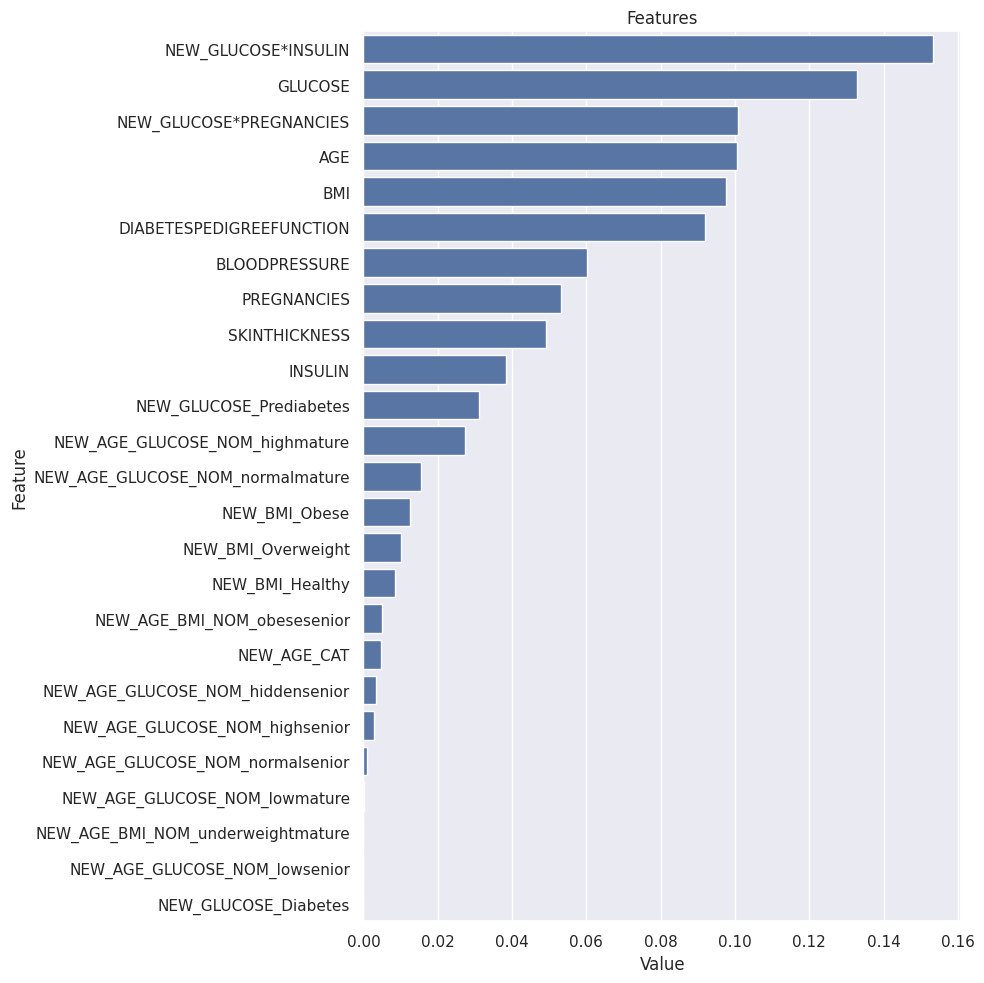

In [155]:
# Yeni oluşturduğumuz değişkenler modelde bir etkiye sahip mi bakalım
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)